In [109]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
import matplotlib.colors as colors
from matplotlib import cm
from IPython.display import HTML
%matplotlib inline

In [110]:
Nx = 5 #Resolution in x
Ny = 5 #Resolution in y
x_range = 20 #Range in x
y_range = 20 #Range in y

#Set up space
x = np.linspace(-x_range/2, x_range/2, Nx+1) #X values. Centered around origin
y = np.linspace(-y_range/2, y_range/2, Ny+1) #Y values. Centered around origin
xx, yy = np.meshgrid(x, y) #Pregenerate the meshgrid of points for all space we care about

print(xx)
print(np.roll(xx, 1, axis=1))
print(-2*xx)
print(np.roll(xx, 1, axis=1))

[[-10.  -6.  -2.   2.   6.  10.]
 [-10.  -6.  -2.   2.   6.  10.]
 [-10.  -6.  -2.   2.   6.  10.]
 [-10.  -6.  -2.   2.   6.  10.]
 [-10.  -6.  -2.   2.   6.  10.]
 [-10.  -6.  -2.   2.   6.  10.]]
[[ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]]
[[ 20.  12.   4.  -4. -12. -20.]
 [ 20.  12.   4.  -4. -12. -20.]
 [ 20.  12.   4.  -4. -12. -20.]
 [ 20.  12.   4.  -4. -12. -20.]
 [ 20.  12.   4.  -4. -12. -20.]
 [ 20.  12.   4.  -4. -12. -20.]]
[[ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]]


In [111]:
def gaussian_2D(x, y, Lx, Ly):
    '''
    Gaussian peak at (Lx, Ly).

    Source: https://github.com/hplgit/INF5620/blob/master/src/wave/wave2D_u0/wave2D_u0.py

    '''
    return np.exp(-(x-Lx)**2 - (y-Ly)**2)

def gaussion_deriv(x, y, Lx, Ly, v=0):
    # returns the initial time derivative of the wave --> u_t(x,0) = V(x)
    return 2*v*((x-Lx)**2 - (y-Ly)**2)*np.exp(-(x-Lx)**2 - (y-Ly)**2)

def f(x, y, t):
    '''
    Driving function, but we don't want one right now.
    '''
    return np.zeros((t.size, *x.shape))

def reflecting_boundary_conditions(u):
    u[:, 0] = 0 #Left wall
    u[:,-1] = 0 #Right wall
    u[0, :] = 0 #Top wall
    u[-1,:] = 0 #Bottom wall
    return u

def propogate(xv, yv, dx, dy, Nt, c=1.0, courant_number=0.1, I=gaussian_2D, V=gaussion_deriv, pos=(0,0)):
    '''
    Propogates a wave through space using a vectorized finite differences method.
    
    WARNING: DON'T FORGET TO DEEP COPY.
    
    Params:
        xv - (1D array) X locations array
        yv - (1D array) Y locations array
        c - (float) Speed of light. Set to 1 usually cause physics and units.
    '''
    
    #*******Pre-computation*********
    states = np.empty((Nt+1, xv.shape[0], xv.shape[1]))
    
    #Initial conditions
    states[0, :, :] = I(xv, yv, *pos) #Initial values
    V_a = V(xv, yv, *pos) #Initial velocities
    rho = np.ones(V_a.shape) #This might be tension, but not quite sure. Change it for fun.
    q = np.ones(V_a.shape)*c**2 #Velocities in space. Change this for refraction
    
    #CFL Condition. 
    #Velocity doesn't change through time, but it could through space
    #so find the maximum time step overall and precalculate.
    #This is general, but we're not currently using a stencil that 
    #supports variable velocities, so be wary
    dt = np.min([courant_number/(q/dy), courant_number/(q/dx)])
    Cx2 = (c*dt/dx)**2
    Cy2 = (c*dt/dy)**2
    print("dt:", dt, "Cx2:", Cx2, "Cy2:", Cy2)
    
    #Now that we have the minimum time step, we can calculate the time range
    t = np.linspace(0, Nt*dt, Nt+1) 
    f_all = f(xv, yv, t)  #Driving function. Precompute at all time for efficiency
    
    #Everything needs to be squared anyways, so let's do it now
    dt2, dx2, dy2 = dt**2, dx**2, dy**2
    
    #*******Iteration*********
    
    #Calculate the first time step
    #states[1, :, :] = vectorized_finite_differencing(states[0, :, :], states[0, :, :], dt, dt2, dx2, dy2, f_all[0], q, rho, V=V_a, first_step=True) #iterate
    states[1, :, :] = vec_fd_constant(states[0, :, :], states[0, :, :], Cx2, Cy2, dt=dt, V=V_a, first_step=True)
    states[1, :, :] = reflecting_boundary_conditions(states[1, :, :]) #reset boundaries
    
    #Continue with recursive algorithm once enough points are calculated.
    for i in range(1, Nt):
        #states[i+1, :, :] = vectorized_finite_differencing(states[i, :, :], states[i-1, :, :], dt, dt2, dx2, dy2, f_all[i], q, rho) #iterate
        states[i+1, :, :] = vec_fd_constant(states[i, :, :], states[i-1, :, :], Cx2, Cy2)
        states[i+1, :, :] = reflecting_boundary_conditions(states[i+1, :, :]) #reset boundaries
    return states

def vec_fd_constant(u_current, u_previous, Cx2, Cy2, dt=None, V=None, first_step=False): 
    '''
    An implementation of a 2D finite differencing algorithm for 
    the wave equation. Implemented using numpy vector manipulation
    instead of iteration for speed.
    
    Reference: https://github.com/hplgit/INF5620/blob/master/src/wave/wave2D_u0/wave2D_u0.py
               http://hplgit.github.io/num-methods-for-PDEs/doc/pub/wave/html/slides_wave-solarized.html#wave:2D3D
    
    Params:
        u_current - (2D array) Grid of solutions at n
        u_last - (2D array) Grid of solutions at n-1
        Cx2 - (float) CFL number for x
        Cy2 - (float) CFL number for y
        dt - (float) Time step for this iteration. Only needed for first step.
        V - (2D array) Initial change in the function u. Only needed for first step.
        first_step - (boolean) True if taking the first step.
    Returns:
        u - (2D array) Grid of solutions at time step n+1
    ''' 
    
    # This does NOT implement a Neumann condition. This abuses python's convenient wraparound indexing,
    # to do a ghost zone of sorts
    u_xx = np.roll(u_current, 1, axis=1) - 2*u_current + np.roll(u_current, -1, axis=1)
    u_yy = np.roll(u_current, 1, axis=0) - 2*u_current + np.roll(u_current, -1, axis=0)
    
    #Different equation for the first time step to rectify the recursive negative time problem. 
    if first_step: return u_current + dt*V + Cx2*u_xx/2 + Cy2*u_yy/2
    
    return (2*u_current - u_previous + Cx2*u_xx + Cy2*u_yy)[:,:]
    

In [112]:
Nx = 300 #Resolution in x
Ny = 300 #Resolution in y
Nt = 5000 #Resolution in time
x_range = 40 #Range in x
y_range = 40 #Range in y

#Set up space
x = np.linspace(-x_range/2, x_range/2, Nx+1) #X values. Centered around origin
y = np.linspace(-y_range/2, y_range/2, Ny+1) #Y values. Centered around origin

dx = x[1] - x[0] #Change in x. Constant across mesh for simplicity.
dy = y[1] - y[0] #Change in y. Constant across mesh for simplicity.

xx, yy = np.meshgrid(x, y) #Pre-generate the meshgrid of points for all space we care about

print("dx:", dx, "| dy:", dy)

#Runs finite differences for the parameters above.
things = propogate(xx, yy, dx, dy, Nt)

#**************Plotting & Stuff***************
plotting = False
printing = False

if plotting:
    initial_values = gaussian_2D(xx, yy, 0, 0)

    fig = plt.figure()
    ax = p3.Axes3D(fig)
    fig.set_size_inches(7, 7)
    surface = ax.plot_surface(xx, yy, initial_values,
                            facecolors=cm.jet(initial_values), shade=False)
    surface.set_facecolor((0,0,0,0))
    plt.show()


for i, thing in enumerate(things):
    if printing: print("Iteration:", i, " | Energy:", np.sum(thing), " | Maximum value:", thing.max())
    
    if (i%15==0) and plotting:
        fig = plt.figure()
        ax = p3.Axes3D(fig)
        fig.set_size_inches(7, 7)
        surface = ax.plot_surface(xx, yy, thing,
                                facecolors=cm.jet(thing), shade=False)
        surface.set_facecolor((0,0,0,0))
        ax.set_zlim(0, 1)
        plt.show()
        
        plt.plot(x, thing[len(thing)//2])
        plt.show()

dx: 0.13333333333333286 | dy: 0.13333333333333286
dt: 0.013333333333333287 Cx2: 0.010000000000000002 Cy2: 0.010000000000000002


<IPython.core.display.Javascript object>


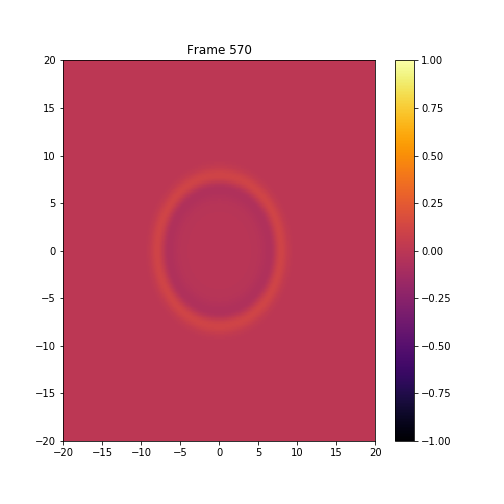

In [115]:
%matplotlib notebook
%matplotlib notebook

fig, ax = plt.subplots()
cax = ax.pcolormesh(x, y, things[0],
                    vmin=-1, vmax=1, cmap='inferno')
fig.colorbar(cax)
fig.set_size_inches(7, 7)
ax.set_title("Frame 0")

def animate_colourmesh(i, things, cax, ax):
    cax.set_array(np.ravel(things[i, :-1, :-1]))
    ax.set_title("Frame "+str(i))
    return cax,

line_ani = animation.FuncAnimation(fig, animate_colourmesh, Nt, fargs=(things, cax, ax),
                                   interval=10, blit=True);

# For windows machine:
saving = False
if saving:
    plt.rcParams['animation.ffmpeg_path'] = 'D:\\Downloads\\ffmpeg-20180227-fa0c9d6-win64-static\\ffmpeg-20180227-fa0c9d6-win64-static\\bin\\ffmpeg.exe'
    FFwriter = animation.FFMpegWriter(fps=60)
    print("Saving")
    line_ani.save('wave_equation_animation_colormap.mp4', writer=FFwriter, dpi=100)
    print("Saved")

In [107]:
HTML(line_ani.to_html5_video())

NameError: name 'HTML' is not defined

<IPython.core.display.Javascript object>


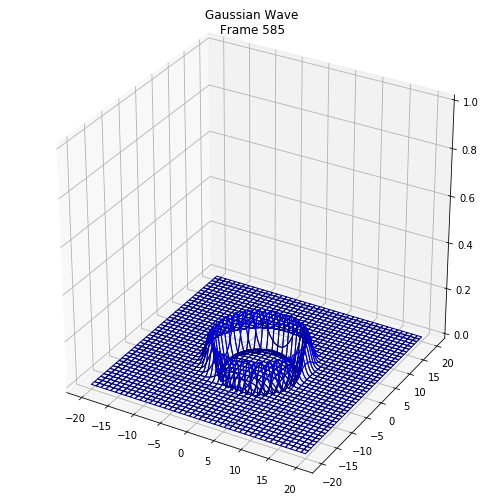

In [85]:
def generate_plot_object(xx, yy, data):
    '''
    A function to generate the lines for a plot to be animated, initialised with the first
    nodes in the data array.
    '''
    #Source: https://matplotlib.org/examples/animation/simple_3danim.html
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    fig.set_size_inches(7, 7)
    
    surface = ax.plot_surface(xx, yy, data[0], rcount=20, ccount=20,
                            facecolors=cm.jet(data[0]), shade=False)
    surface.set_facecolor((0,0,0,0))
    
    # Setting the axes properties
    ax.set_xlim3d([-x_range/2, x_range/2])
    ax.set_xlabel('X')

    ax.set_ylim3d([-y_range/2, y_range/2])
    ax.set_ylabel('Y')

    ax.set_zlim3d([0.0, 1.0])
    ax.set_zlabel('Z')

    ax.set_title('Gaussian Wave\nFrame 0')
    #fig.colorbar()
    
    return fig, ax, surface

def animate_wireframe(num, data, ax):
    ax.clear()
    ax.set_zlim(0, 1)
    ax.set_title('Gaussian Wave\nFrame ' + str(num))

    surface = ax.plot_surface(xx, yy, data[num],
                            facecolors=cm.jet(data[num]), shade=False)
    surface.set_facecolor((0,0,0,0))

    return surface,

fig, ax, surfaces = generate_plot_object(xx, yy, things)

line_ani = animation.FuncAnimation(fig, animate_wireframe, Nt, fargs=(things, ax),
                                   interval=30, blit=True);

# For a mac (sorta, needs to be modified a little bit):
# Uncomment these lines to save the animation. 
# Please make sure that you download ffmpeg and then set the pointer to the correct location for your system
#plt.rcParams['animation.ffmpeg_path'] = '/home/nathan.meulenbroek/miniconda3/bin'
#line_ani.save('lorentz_system.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# For windows machine:
saving = False
if saving:
    plt.rcParams['animation.ffmpeg_path'] = 'D:\\Downloads\\ffmpeg-20180227-fa0c9d6-win64-static\\ffmpeg-20180227-fa0c9d6-win64-static\\bin\\ffmpeg.exe'
    FFwriter = animation.FFMpegWriter(fps=60)
    print("Saving")
    line_ani.save('wave_equation_animation_wireframe.mp4', writer=FFwriter, dpi=100)
    print("Saved")

In [ ]:
def vectorized_finite_differencing(u_current, u_previous, dt, dt2, dx2, dy2, driving_fn, q, rho, V=None, first_step=False):
    '''
    An implementation of a 2D finite differencing algorithm for 
    the wave equation. Implemented using numpy vector manipulation
    instead of iteration for speed.
    
    Reference: https://github.com/hplgit/INF5620/blob/master/src/wave/wave2D_u0/wave2D_u0.py
               http://hplgit.github.io/num-methods-for-PDEs/doc/pub/wave/html/slides_wave-solarized.html#wave:2D3D
    Params:
        u_current - (2D array) Grid of solutions at n
        u_last - (2D array) Grid of solutions at n-1
        dt - (float) Time step for this iteration
        fn - (2D array) Driving function, precalculated and in array format
        q - (2D array) Speed coefficient
        rho - (2D array) 
    Returns:
        u - (2D array) Grid of solutions at time step n+1
    ''' 
    
    # This does NOT implement a Neumann condition. This abuses python's convenient wraparound indexing,
    # which is fine as long as we don't hit the edge, or we only want to do reflection anyways.
    u_xx = (np.roll(q, 1, axis=1)+q)*(np.roll(u_current, 1, axis=1) - u_current) - (q+np.roll(q, -1, axis=1))*(np.roll(u_current, -1, axis=1) - u_current)    #u_yy = (q+np.roll(q, 1, axis=0))*(np.roll(u_current, 1, axis=0) - u_current) - (q+np.roll(q, -1, axis=0))*(np.roll(u_current, -1, axis=0) - u_current)
    #u_xx = np.roll(u_current, 1, axis=1) - 2*u_current + np.roll(u_current, -1, axis=1)
    #u_yy = (np.roll(u_current, 1, axis=0)-2*u_current+np.roll(u_current, 1, axis=0))
    
    #print(np.sum(u_xx), np.sum(u_yy), np.sum((q+np.roll(q, 1, axis=0))*(np.roll(u_current, 1, axis=0) - u_current)))
    #print(np.sum(np.roll(u_current, 1, axis=0)), u_current)
    
    
    #Different equation for the first time step to rectify the recursive negative time problem. 
    #if first_step: return u_current - dt*V + (dt**2)*((u_xx/dx**2 + u_yy/dy**2)/(4*rho) + driving_fn[i]/2)
    if first_step: return u_current - dt*V + q*dt2*(u_xx/dx2 )/4 #+ q*dt2*(u_xx/dx2 + u_yy/dy2 )/2
    
    #print(np.roll(u_current, 1, axis=0) - u_current)
    #print("Change:", np.round(dt2*(u_xx + u_yy)/2, 4))
    
    #return 2*u_current - u_last + (dt**2)*((u_xx/dx**2 + u_yy/dy**2)/(4*rho) + driving_fn[i]/2)
    return 2*u_current - u_previous + q*dt2*(u_xx/dx2 )/2 #+ q*dt2*(u_xx/dx2 + u_yy/dy2 )/2